# Imports

In [1]:
import os
from glob import glob
from tqdm.notebook import tqdm
from coreLib.utils import *
import numpy as np
import cv2
import itertools
import scipy.ndimage
import matplotlib.pyplot as plt
%matplotlib inline


# Globals


In [2]:
data_path="/media/ansary/DriveData/Work/LEAF/dataset/raw/"
save_path="/media/ansary/DriveData/Work/LEAF/dataset/"
proc_save=create_dir(save_path,'proc')
mask_save=create_dir(save_path,'mask')

save_path=create_dir(save_path,'data')

train_save=create_dir(save_path,'train')
test_save=create_dir(save_path,'test')


# Test Train  Split

In [3]:
classes=os.listdir(data_path)
for _class in classes:
    create_dir(train_save,_class)
    create_dir(test_save,_class)
    create_dir(proc_save,_class)
    create_dir(mask_save,_class)
    

In [4]:
import numpy as np
from skimage.measure import label   

    
def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=4, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))
        
for _class in tqdm(classes):
    img_paths=[img_path for img_path in glob(os.path.join(data_path,_class,"*.*"))]
    for img_path in tqdm(img_paths):
        img = cv2.imread(img_path)
        img=kmeans_color_quantization(img)
        base_name=os.path.basename(img_path)
        cv2.imwrite(os.path.join(mask_save,_class,base_name),img)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
IMG_4861.jpg

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

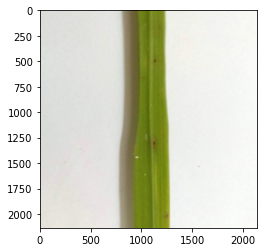

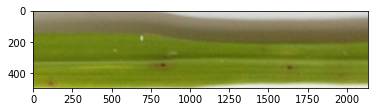

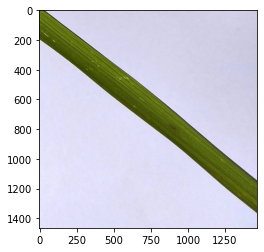

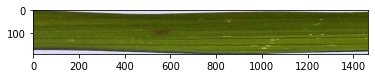

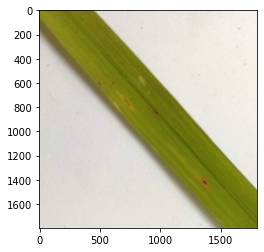

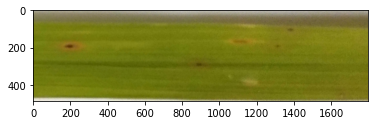

KeyboardInterrupt: 

In [5]:
import random
for _class in tqdm(classes):
    img_paths=[img_path for img_path in glob(os.path.join(data_path,_class,"*.*"))]
    random.shuffle(img_paths)
    for img_path in tqdm(img_paths):       
        # read
        org=cv2.imread(img_path)
        plt.imshow(cv2.cvtColor(org,cv2.COLOR_BGR2RGB))
        plt.show()
        # gray
        img=cv2.cvtColor(org, cv2.COLOR_BGR2GRAY)
        # threshold
        blur = cv2.GaussianBlur(img,(5,5),0)
        _,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # invert
        img=255-img
        # highest
        img=getLargestCC(img)
        img=img.astype("uint8")
        # rotated
        coords = np.column_stack(np.where(img > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle
        (h, w) = img.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        org = cv2.warpAffine(org, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        # crop
        idx = np.where(img>0)
        y,h,x,w = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
        
        org=org[y:h,x:w]
        img=img[y:h,x:w]
        # final
        h,w,d=org.shape
        if h>w:
            org = cv2.rotate(org, cv2.cv2.ROTATE_90_CLOCKWISE)
        '''
        cv2.imwrite(os.path.join(proc_save,_class,f"{cnt}.png"),org)
        cnt+=1
        '''
        plt.imshow(cv2.cvtColor(org,cv2.COLOR_BGR2RGB))
        plt.show()
        

In [8]:
def save_combinations(_paths,_save,data_dim=256,max_count=10000):
    '''
        for eval and train images:
        * creates collages for 4 combs
        args:
            _paths   : the raw image paths
            _save    : the directory to save the images
            data_dim : the dimension of the data to save
            max_count: number of maximum combination images
    '''
    iden="comb"
    count=0
    for comb in tqdm(itertools.combinations(_paths, 4)):
        if count==max_count:
            break
        _img0=cv2.imread(comb[0])
        _img1=cv2.imread(comb[1])
        _img2=cv2.imread(comb[2])
        _img3=cv2.imread(comb[3])
        # width
        _img01=np.concatenate([_img0,_img1],axis=1)
        _img23=np.concatenate([_img2,_img3],axis=1)
        # height
        _img=np.concatenate([_img01,_img23],axis=0)
        _img=cv2.resize(_img,(data_dim,data_dim))
        # save
        cv2.imwrite(os.path.join(_save,f"comb_{count}.png"),_img)
        count+=1

        
        
        
    
    

for _class in tqdm(classes):
    train_paths=[img_path for img_path in glob(os.path.join(train_save,_class,"*.*"))]
    eval_paths=[img_path for img_path in glob(os.path.join(eval_save,_class,"*.*"))]
    # train
    save_combinations(train_paths,os.path.join(train_save,_class))
    # eval
    save_combinations(eval_paths,os.path.join(eval_save,_class),max_count=100)
    

  0%|          | 0/3 [00:00<?, ?it/s]

NameError: name 'eval_save' is not defined

# ImageAug

In [6]:
# image aug
ia.seed(1)
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order


In [7]:
def save_augs(_paths,_save):
    '''
        for eval and train images:
        * creates collages for 4 combs
        args:
            _paths  : the raw image paths
            _save   : the directory to save the images
            data_dim: the dimension of the data to save
    '''
    count=0
    for img_path in tqdm(_paths):
        img=cv2.imread(img_path)
        # aug
        img=[img]
        img= seq(images=img)[0]
        # save
        cv2.imwrite(os.path.join(_save,f"aug_{count}.png"),img)
        count+=1


for _class in tqdm(classes):
    train_paths=[img_path for img_path in glob(os.path.join(train_save,_class,"*.*"))]
    eval_paths=[img_path for img_path in glob(os.path.join(eval_save,_class,"*.*"))]
    # train
    save_augs(train_paths,os.path.join(train_save,_class))
    # eval
    save_augs(eval_paths,os.path.join(eval_save,_class))
    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]